In [1]:
import scipy.io as scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn import preprocessing
import tensorflow as tf
import os
import librosa.display

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
a = '/content/drive/MyDrive/Inertial/a'
b = '_s'
c = '_t'
d = '_inertial.mat'

file_list = []
for i in range(10,20):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(1,2):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(20,28):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
for i in range(2,10):
  for j in range(1,9):
    for k in range(1,5):
      file_path = a + str(i)+b+str(j)+c+str(k)+d
      file_list.append(file_path)
file_list.remove('/content/drive/MyDrive/Inertial/a8_s1_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a23_s6_t4_inertial.mat')
file_list.remove('/content/drive/MyDrive/Inertial/a27_s8_t4_inertial.mat')

In [ ]:
file_list

In [5]:
def melspectrum(data):
        data_x = data[:,0]
        data_y = data[:,1]
        data_z = data[:,2]
        data_x = data_x.reshape(-1)
        data_y = data_y.reshape(-1)
        data_z = data_z.reshape(-1)
        data_xx = np.interp(np.linspace(0, data_x.size, 10000), np.arange(data_x.size), data_x)
        Sx = librosa.feature.melspectrogram(data_xx, sr=100)
        Sx_dB = librosa.power_to_db(Sx, ref=np.max)
        data_yy = np.interp(np.linspace(0, data_y.size, 10000), np.arange(data_y.size), data_y)
        Sy = librosa.feature.melspectrogram(data_yy, sr=100)
        Sy_dB = librosa.power_to_db(Sy, ref=np.max)
        data_zz = np.interp(np.linspace(0, data_z.size, 10000), np.arange(data_z.size), data_z)
        Sz = librosa.feature.melspectrogram(data_zz, sr=100)
        Sz_dB = librosa.power_to_db(Sz, ref=np.max)
        S_db = np.dstack((Sx_dB, Sy_dB, Sz_dB))
        S_norm = S_db-S_db.min()
        S_norm /= S_norm.max()
        return S_norm

In [6]:
def load_data(data_directory):
    file_names = file_list
    train_labels = []
    train_datas = []
    test_labels = []
    test_datas = []
    train_split = [1,3,5,7]
    for d in file_names:
        label = d[-21:-19]
        if 'a' in label[0]:
            label = label[-1]
        label = int(label)
        if label == 27:
          label = 0
        if int(d[-17:-16]) in train_split:
            train_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            train_datas.append(S_norm)
        else:
            test_labels.append(label)
            data = scipy.loadmat(d)
            data = data['d_iner'][:,:3]
            S_norm = melspectrum(data)
            test_datas.append(S_norm) 
    train_labels = np.array(train_labels)
    train_datas = np.array(train_datas)
    test_labels = np.array(test_labels)
    test_datas = np.array(test_datas)
    return train_labels,train_datas,test_labels,test_datas

In [7]:
data_directory = '/content/drive/MyDrive/Inertial'
train_labels,train_datas,test_labels,test_datas = load_data(data_directory)

In [8]:
train_arr = np.arange(train_datas.shape[0])
test_arr = np.arange(test_datas.shape[0])

np.random.seed(822)
np.random.shuffle(train_arr)
np.random.shuffle(test_arr)
train_datas_shuffled = train_datas[train_arr]
train_labels_shuffled = train_labels[train_arr]
test_datas_shuffled = test_datas[test_arr]
test_labels_shuffled = test_labels[test_arr]
print(train_datas_shuffled.shape)

(431, 128, 20, 3)


In [9]:
train_datas = tf.image.resize(train_datas_shuffled,[224,224])
test_datas = tf.image.resize(test_datas_shuffled,[224,224])
train_labels = train_labels_shuffled
test_labels = test_labels_shuffled

In [10]:
train_datas = (train_datas-0.5)*2
test_datas = (test_datas-0.5)*2

In [11]:
max = np.max(train_datas)
min = np.min(train_datas)
print(max)
print(min)

1.0
-1.0


In [12]:
valid_datas = test_datas
valid_labels = test_labels
#valid_datas = test_datas[0:100]
#valid_labels = test_labels[0:100]
#test_datas = test_datas[101:]
#test_labels = test_labels[101:]
print(train_datas.shape)
print(test_datas.shape)
print(valid_datas.shape)

(431, 224, 224, 3)
(430, 224, 224, 3)
(430, 224, 224, 3)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_datas, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_datas, valid_labels))

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
#train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
#valid_dataset = valid_datas.cache().prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

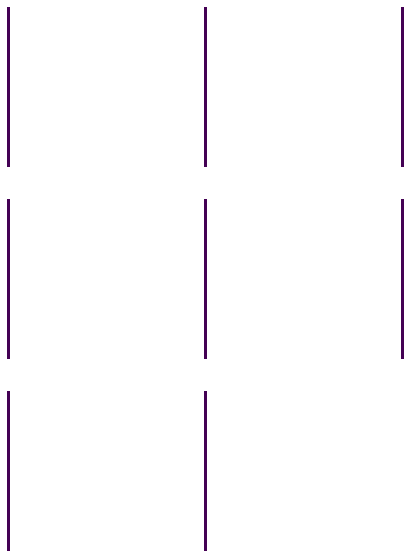

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = train_datas.shape[0]
batch_size = 8
train_dataset = train_dataset.shuffle(buffer_size=buffer_size)\
                    .batch(batch_size,drop_remainder=True).prefetch(AUTOTUNE)

valid_dataset = valid_dataset.batch(batch_size,drop_remainder=True).prefetch(AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch)
  break

(8, 224, 224, 3)
(8,)
tf.Tensor([10 16  6  0  9 23  8 14], shape=(8,), dtype=int64)


In [ ]:
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel('Batch number')
  plt.ylabel('Batch size')

In [ ]:
x_train = train_datas
y_train = train_labels
x_test = test_datas
y_test = test_labels

**Trainning**

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

ModuleNotFoundError: ignored

In [17]:
def mlp(x, hidden_units, l1=0.0001, l2=0.0001,dropout_rate=0):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2))(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config().copy()
        config.update({"patch_size": self.patch_size})
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config().copy()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection.units})
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes,
    l1=0.0001,
    l2=0.0001
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, l1=l1, l2=l2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, l1=l1, l2=l2,dropout_rate=0.3)

    # Classification head
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    # return Keras model
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
#    optimizer = tfa.optimizers.AdamW(
#        learning_rate=learning_rate, weight_decay=weight_decay    )
    sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,decay=1e-6,momentum=0.9,nesterov=True)
    optimizer = sgd

    # Compile model.
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
    checkpoint_filepath = '/content/drive/MyDrive/transformer_HAR/inertial_transformer_checkpoint/inertial_transformer_weights_L1L2_dropout_latest.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)  
    model.load_weights('/content/drive/MyDrive/transformer_HAR/inertial_transformer_checkpoint/inertial_transformer_weights_L1L2_dropout_latest.h5')
    history = model.fit(train_dataset, validation_data = valid_dataset,epochs = 100,callbacks=[model_checkpoint_callback])

    return history

image_size = 224
patch_size = 16
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 200
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_classes = 27
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [1024, 512]  # Size of the dense layers


num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes = 27
)


# Train model
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
53/53 [==============================] - 35s 566ms/step - loss: 0.9585 - accuracy: 1.0000 - val_loss: 2.6121 - val_accuracy: 0.6250
Epoch 2/100
53/53 [==============================] - 28s 533ms/step - loss: 0.9594 - accuracy: 0.9953 - val_loss: 2.7445 - val_accuracy: 0.6038
Epoch 3/100
53/53 [==============================] - 28s 533ms/step - loss: 0.9391 - accuracy: 1.0000 - val_loss: 2.6579 - val_accuracy: 0.6085
Epoch 4/100
53/53 [==============================] - 28s 532ms/step - loss: 0.9556 - accuracy: 0.9906 - val_loss: 2.7710 - val_accuracy: 0.6014
Epoch 5/100
53/53 [==============================] - 28s 532ms/step - loss: 0.9381 - accuracy: 1.0000 - val_loss: 2.6697 - val_accuracy: 0.6132
Epoch 6/100
53/53 [==============================] - 28s 527ms/step - loss: 0.9485 - accuracy: 0.9906 - val_loss: 2.6444 - val_accuracy: 0.6085
Epoch 7/100
53/53 [==============================] - 29s 550ms/step - loss: 0.9481 - accuracy: 0.9953 - val_loss: 2.7100 - val_accuracy:

In [ ]:
for layer in vit.layers:
    layer._name = layer.name + '_inertial'
#x = Dense(512, activation='relu')(x)
#x = Dense(128, activation='relu')(x)

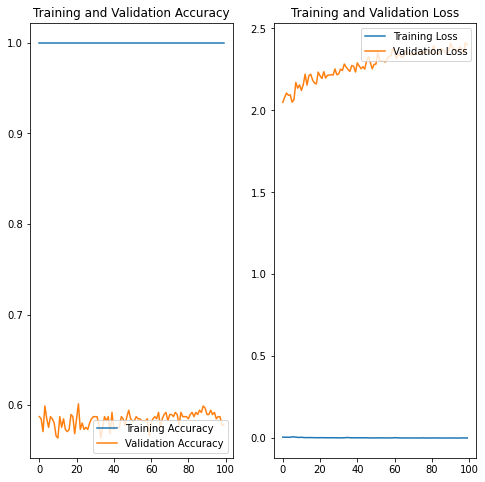

In [ ]:
epochs = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
with open("/content/drive/MyDrive/transformer_HAR/inertial_transformer_checkpoint/inertial_result_vit.txt", "w") as file:
    for item in acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_acc:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in loss:
        file.write(str(item) + "\n")
    file.write("\n")
    for item in val_loss:
        file.write(str(item) + "\n")

In [18]:

image_size = 224
patch_size = 16
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 8
num_epochs = 200
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_classes = 27
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [1024, 512]  # Size of the dense layers


num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_classifier(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes = 27
)

model = vit_object_detector
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.001,decay=1e-6,momentum=0.9,nesterov=True)
optimizer = sgd
# Train model
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model.load_weights('/content/drive/MyDrive/transformer_HAR/inertial_transformer_checkpoint/inertial_transformer_weights_L1L2_dropout_latest.h5')

In [20]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
predictions = model.predict(x=valid_datas,batch_size=8,verbose=0)
rounded_predictions = np.argmax(predictions,axis=-1)
cm = confusion_matrix(y_true=valid_labels, y_pred=rounded_predictions)
def plot_confusion_matrix(cm, classes = None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#    tick_marks = np.arange(len(classes))
#    plt.xticks(tick_marks, classes, rotation=45)
#    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
count = 0
true = 0
for i in range(27):
  for j in range(len(valid_labels)):
    if valid_labels[j] == i:
      count += 1
      if valid_labels[j] - rounded_predictions[j] == 0:
        true += 1
  acc = true / count
  print(acc)
  count = 0
  true = 0

1.0
0.8125
0.5625
1.0
0.9375
0.3125
0.625
0.3125
0.0
0.4375
0.375
0.25
0.8125
0.6875
0.75
0.5
0.5625
0.8125
0.75
0.4375
0.25
0.875
0.6875
1.0
0.6875
1.0
0.8125
